<a href="https://colab.research.google.com/github/snowshine/NFTCreators/blob/main/gan/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Reshape, Dropout, Dense 
from tensorflow.keras.layers import Flatten, BatchNormalization
from tensorflow.keras.layers import Activation, ZeroPadding2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam

import numpy as np
from PIL import Image
from tqdm import tqdm
import os 
import time
import matplotlib.pyplot as plt


In [ ]:
tf.__version__, tf.test.gpu_device_name()

('2.8.0', '/device:GPU:0')

In [1]:
from google.colab import drive
drive.mount('/content/drive')
# drive._mount('/content/drive')
# drive.mount("/content/drive", force_remount=True)

# change working directory
%cd /content/drive/Shareddrives/Capstone/
!ls -art

Mounted at /content/drive
/content/drive/Shareddrives/Capstone
cryptopunks.zip		   crytopunks_image_data      cryptopunks32.npz
mutant-ape-yacht-club.zip  mutant_image_data	      cryptopunks.npz
mutant-ape-yacht-club	   mutant-ape-yacht-club.npz
cryptopunks		   cryptopunks32_0.npz


In [3]:
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60.
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)

### Build the discriminator and the generator model

In [4]:
def build_generator(seed_size, channels):
    model = Sequential()

    model.add(Dense(4*4*256,activation="relu",input_dim=seed_size))
    model.add(Reshape((4,4,256)))

    model.add(UpSampling2D())
    model.add(Conv2D(256,kernel_size=3,padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))

    model.add(UpSampling2D())
    model.add(Conv2D(256,kernel_size=3,padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))
   
    # Output resolution, additional upsampling
    model.add(UpSampling2D())
    model.add(Conv2D(128,kernel_size=3,padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))

    if GENERATE_RES>1:
      model.add(UpSampling2D(size=(GENERATE_RES,GENERATE_RES)))
      model.add(Conv2D(128,kernel_size=3,padding="same"))
      model.add(BatchNormalization(momentum=0.8))
      model.add(Activation("relu"))

    # Final CNN layer
    model.add(Conv2D(channels,kernel_size=3,padding="same"))
    model.add(Activation("tanh"))

    return model


def build_discriminator(image_shape):
    model = Sequential()

    model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=image_shape, 
                     padding="same"))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
    model.add(ZeroPadding2D(padding=((0,1),(0,1))))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Conv2D(512, kernel_size=3, strides=1, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    return model

In [5]:
# define loss function
cross_entropy = tf.keras.losses.BinaryCrossentropy()

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

As we progress through training images will be produced to show the progress. These images will contain a number of rendered image data that show how good the generator has become.

In [6]:
# define generated image resolution (as square like 128x128 and multiple of 32)
# 128×128 resolution is the highest we can go for Google CoLab (with GPU). 
# The higher the resolution, the more memory that will be needed, also longer run times
GENERATE_RES = 1 # Generation resolution factor (1=32, 2=64, 3=96, 4=128, etc.)
# GENERATE_RES = 4 # Generation resolution factor (1=32, 2=64, 3=96, 4=128, etc.)
GENERATE_SQUARE = 32 * GENERATE_RES # rows/cols (should be square)
IMAGE_CHANNELS = 3
print(f"Will generate {GENERATE_SQUARE}px square images.")

# Preview image setting
# PREVIEW_ROWS = 4
# PREVIEW_COLS = 7
# PREVIEW_MARGIN = 16
PREVIEW_ROWS = 2
PREVIEW_COLS = 3
PREVIEW_MARGIN = 16

from PIL import Image
def save_images(cnt, noise, output_path):
  image_array = np.full(( 
      PREVIEW_MARGIN + (PREVIEW_ROWS * (GENERATE_SQUARE+PREVIEW_MARGIN)), 
      PREVIEW_MARGIN + (PREVIEW_COLS * (GENERATE_SQUARE+PREVIEW_MARGIN)), 3), 
      255, dtype=np.uint8)
  
  generated_images = generator.predict(noise)

  generated_images = 0.5 * generated_images + 0.5

  image_count = 0
  for row in range(PREVIEW_ROWS):
      for col in range(PREVIEW_COLS):
        r = row * (GENERATE_SQUARE+16) + PREVIEW_MARGIN  #16,64
        c = col * (GENERATE_SQUARE+16) + PREVIEW_MARGIN  #16,64,112
        print('r=', r, '; c=', c)      
        image_array[r:r+GENERATE_SQUARE,c:c+GENERATE_SQUARE] = generated_images[image_count] * 255
        image_count += 1
  
  if not os.path.exists(output_path):
    os.makedirs(output_path)
    
  filename = os.path.join(output_path,f"train-{cnt}.png")
  im = Image.fromarray(image_array)
  im.save(filename)
  plt.imshow(im)

Will generate 32px square images.


In [7]:
# use Adam and the same learning rate and momentum for both generator and discriminator. 
# need to tune the learning rates and other hyperparameters for higher image resolution (GENERATE_RES>3)
generator_optimizer = tf.keras.optimizers.Adam(1.5e-4,0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(1.5e-4,0.5)

# based on: https://www.tensorflow.org/tutorials/generative/dcgan
@tf.function
def train_step(images, batch_size, seed_size):
  # seed = tf.random.normal([BATCH_SIZE, SEED_SIZE])
  seed = tf.random.normal([batch_size, seed_size])

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator(seed, training=True)

    real_output = discriminator(images, training=True)
    fake_output = discriminator(generated_images, training=True)

    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(real_output, fake_output)
    
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
  return gen_loss,disc_loss

In [9]:
def train(dataset, epochs, batch_size, seed_size, output_path = 'output'):
  
  start = time.time()
  # print(start)

  for epoch in range(epochs):
    epoch_start = time.time()

    gen_loss_list = []
    disc_loss_list = []

    for image_batch in dataset:
      t = train_step(image_batch, batch_size, seed_size)
      gen_loss_list.append(t[0])
      disc_loss_list.append(t[1])

    g_loss = sum(gen_loss_list) / len(gen_loss_list)
    d_loss = sum(disc_loss_list) / len(disc_loss_list)

    epoch_elapsed = time.time()-epoch_start
    print (f'Epoch {epoch+1}, gen loss={g_loss},disc loss={d_loss}, time={hms_string(epoch_elapsed)}')

    fixed_seed = np.random.normal(0, 1, (PREVIEW_ROWS * PREVIEW_COLS, SEED_SIZE))
    save_images(epoch, fixed_seed, output_path)

  elapsed = time.time()-start
  print (f'Training time: {hms_string(elapsed)}')

In [13]:
EPOCHS = 10 #50
BATCH_SIZE = 32
BUFFER_SIZE = 60000
SEED_SIZE = 100  # Size vector to generate images from

def loadDataset(collection, buffer_size=BUFFER_SIZE, batch_size=BATCH_SIZE):
  np_data = np.load(collection + '.npz')['arr_0']
 
  # use TensorFlow Dataset object to hold the images, so the data can be quickly shuffled and divided into the appropriate batch sizes for training.
  train_dataset = tf.data.Dataset.from_tensor_slices(np_data).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

  return train_dataset

train_dataset = loadDataset('/content/drive/Shareddrives/Capstone/cryptopunks32')
# train_dataset = loadDataset('cryptopunks32')
# loadDataset('mutant-ape-yacht-club')

iterator = iter(train_dataset)
iterator.get_next().shape  # shape=(32, 32, 32, 3)

TensorShape([32, 32, 32, 3])

tf.Tensor([[0.5002206]], shape=(1, 1), dtype=float32)


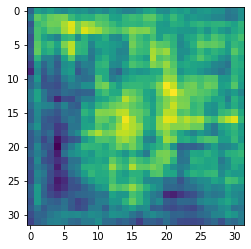

In [11]:
generator = build_generator(SEED_SIZE, IMAGE_CHANNELS)

noise = tf.random.normal([1, SEED_SIZE])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0])

image_shape = (GENERATE_SQUARE,GENERATE_SQUARE,IMAGE_CHANNELS)

discriminator = build_discriminator(image_shape)
decision = discriminator(generated_image)
print (decision)


Epoch 1, gen loss=3.9119720458984375,disc loss=0.508361279964447, time=0:00:13.48
r= 16 ; c= 16
r= 16 ; c= 64
r= 16 ; c= 112
r= 64 ; c= 16
r= 64 ; c= 64
r= 64 ; c= 112
Epoch 2, gen loss=3.548191547393799,disc loss=0.5295703411102295, time=0:00:07.39
r= 16 ; c= 16
r= 16 ; c= 64
r= 16 ; c= 112
r= 64 ; c= 16
r= 64 ; c= 64
r= 64 ; c= 112
Epoch 3, gen loss=3.545600175857544,disc loss=0.5440691113471985, time=0:00:07.42
r= 16 ; c= 16
r= 16 ; c= 64
r= 16 ; c= 112
r= 64 ; c= 16
r= 64 ; c= 64
r= 64 ; c= 112
Epoch 4, gen loss=3.3420522212982178,disc loss=0.5442802906036377, time=0:00:07.47
r= 16 ; c= 16
r= 16 ; c= 64
r= 16 ; c= 112
r= 64 ; c= 16
r= 64 ; c= 64
r= 64 ; c= 112
Epoch 5, gen loss=3.424907684326172,disc loss=0.5170653462409973, time=0:00:07.87
r= 16 ; c= 16
r= 16 ; c= 64
r= 16 ; c= 112
r= 64 ; c= 16
r= 64 ; c= 64
r= 64 ; c= 112
Epoch 6, gen loss=3.3379857540130615,disc loss=0.4889592230319977, time=0:00:07.56
r= 16 ; c= 16
r= 16 ; c= 64
r= 16 ; c= 112
r= 64 ; c= 16
r= 64 ; c= 64
r= 64

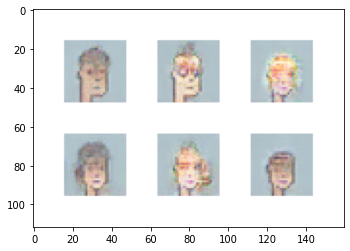

In [14]:
# start training

train(train_dataset, EPOCHS, BATCH_SIZE, SEED_SIZE)

In [15]:
# from PIL import Image
# image = Image.open('/content/drive/Shareddrives/Capstone/cryptopunks/0000.png')
image = Image.open('/content/drive/Shareddrives/Capstone/output/train-0.png')
# image.show()

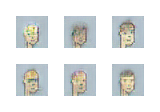

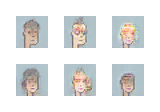

(None, None)

In [21]:
from IPython.display import display, Image
# display(Image(filename='/content/drive/Shareddrives/Capstone/cryptopunks/0000.png'))
display(Image(filename='/content/drive/Shareddrives/Capstone/output/train-4.png')), 
display(Image(filename='/content/drive/Shareddrives/Capstone/output/train-9.png'))